# PixelCNN

Partially inspired by https://github.com/heechan95/PixelRNN-pytorch/blob/master/PixelRNN%20pytorch.ipynb

In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T

In [2]:
# PARAMETERS
NUM_EPOCHS = 50
BATCH_SIZE = 128
HIDDEN_DIM = 16
LR = 1e-3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Masked Convolutions

In [3]:
class MaskedConvolution(nn.Module):
    def __init__(self,
                in_channels,
                out_channels,
                kernel_size=(3,3),
                mask_type='B'):
        super().__init__()
        
        # determine the mask
        assert mask_type in ['A', 'B']
        mask = torch.zeros(kernel_size)
        mask[: kernel_size[0] // 2, :] = 1
        if mask_type == 'A':
            mask[kernel_size[0] // 2, : kernel_size[1] // 2] = 1
        elif mask_type == 'B':
            mask[kernel_size[0] // 2, : kernel_size[1] // 2 + 1] = 1
        self.register_buffer('mask', mask)
        
        # add conv2d layer
        padding = tuple([(size-1)//2 for size in kernel_size])
        self.conv = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              padding=padding)
        
    def forward(self, x):
        with torch.inference_mode():
            self.conv.weight *= self.mask 
        return self.conv(x)

In [4]:
# test the MaskedConvolution layer
mc = MaskedConvolution(in_channels=1, out_channels=16, kernel_size=(3, 3), mask_type='B').to(DEVICE)
data = torch.randn(1, 1, 28, 28, device=DEVICE)
mc(data).shape

torch.Size([1, 16, 28, 28])

## Residual Block

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=hidden_dim*2, out_channels=hidden_dim, kernel_size=1),
            nn.ReLU(),
            MaskedConvolution(in_channels=hidden_dim, out_channels=hidden_dim),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_dim, out_channels=hidden_dim*2, kernel_size=1),
            nn.ReLU()
        )
        
    def forward(self, x):
        block = self.block(x)
        return x + block

In [6]:
# test residual block
block = ResidualBlock(16).to(DEVICE)
img = torch.randn(1, 32, 28, 28, device=DEVICE)
block(img).shape

torch.Size([1, 32, 28, 28])

## PixelCNN

In [7]:
class PixelCNN(nn.Module):
    
    def __init__(self, hidden_dim):
        super().__init__()
        self.layers = nn.Sequential(
                MaskedConvolution(in_channels=1, 
                                  out_channels=hidden_dim*2,
                                  kernel_size=(7, 7),
                                  mask_type='A'),
                nn.ReLU(),
                ResidualBlock(hidden_dim),
                ResidualBlock(hidden_dim),
                ResidualBlock(hidden_dim),
                ResidualBlock(hidden_dim),
                ResidualBlock(hidden_dim),
                ResidualBlock(hidden_dim),
                ResidualBlock(hidden_dim),
                nn.Conv2d(hidden_dim*2, hidden_dim*2, kernel_size=1),
                nn.ReLU(),
                nn.Conv2d(hidden_dim*2, 256, kernel_size=1)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.view(-1, 256, 1, 28, 28)
        return x

In [8]:
test_images = torch.randn(BATCH_SIZE, 1, 28, 28, device=DEVICE)
model = PixelCNN(16).to(DEVICE)
model(test_images).shape

torch.Size([128, 256, 1, 28, 28])

In [9]:
train_dataset = torchvision.datasets.MNIST(root='../datasets/', 
                                           train=True, 
                                           transform=T.PILToTensor(), 
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../datasets/', 
                                           train=False, 
                                           transform=T.PILToTensor(), 
                                           download=False)

In [10]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=2)

In [12]:
model = PixelCNN(HIDDEN_DIM).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=True)

In [13]:
def train():
    for epoch in range(1, NUM_EPOCHS+1):
        train_losses = []
        test_losses = []
        for features, _ in tqdm(train_dataloader, leave=False):
            features = features.to(DEVICE)
            logits = model(features.float() / 255)
            loss = criterion(logits, features.long())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.cpu().item())
        
        # inference
        with torch.inference_mode():
            for features, _ in test_dataloader:
                features = features.to(DEVICE)
                logits = model(features.float() / 255)
                loss = criterion(logits, features.long())
                test_losses.append(loss.cpu().item())

        ce_train = sum(train_losses)/len(train_losses)
        ce_test = sum(test_losses)/len(test_losses)
        print(f'Epoch: {epoch}/{NUM_EPOCHS}, Cross Entropy Train: {ce_train:.4f}, Cross Entropy Test: {ce_test:.4f}')
        scheduler.step(ce_test)

In [14]:
train()

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 1/50, Cross Entropy Train: 1.2836, Cross Entropy Test: 0.8368


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 2/50, Cross Entropy Train: 0.8289, Cross Entropy Test: 0.8176


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 3/50, Cross Entropy Train: 0.8162, Cross Entropy Test: 0.8091


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 4/50, Cross Entropy Train: 0.8093, Cross Entropy Test: 0.8024


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 5/50, Cross Entropy Train: 0.8039, Cross Entropy Test: 0.7977


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 6/50, Cross Entropy Train: 0.8000, Cross Entropy Test: 0.7957


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 7/50, Cross Entropy Train: 0.7969, Cross Entropy Test: 0.7946


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 8/50, Cross Entropy Train: 0.7942, Cross Entropy Test: 0.7931


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 9/50, Cross Entropy Train: 0.7917, Cross Entropy Test: 0.7872


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 10/50, Cross Entropy Train: 0.7897, Cross Entropy Test: 0.7867


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 11/50, Cross Entropy Train: 0.7879, Cross Entropy Test: 0.7831


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 12/50, Cross Entropy Train: 0.7861, Cross Entropy Test: 0.7825


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 13/50, Cross Entropy Train: 0.7847, Cross Entropy Test: 0.7799


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 14/50, Cross Entropy Train: 0.7835, Cross Entropy Test: 0.7809


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 15/50, Cross Entropy Train: 0.7814, Cross Entropy Test: 0.7768


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 16/50, Cross Entropy Train: 0.7801, Cross Entropy Test: 0.7768


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 17/50, Cross Entropy Train: 0.7786, Cross Entropy Test: 0.7785


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 18/50, Cross Entropy Train: 0.7775, Cross Entropy Test: 0.7706


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 19/50, Cross Entropy Train: 0.7762, Cross Entropy Test: 0.7843


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 20/50, Cross Entropy Train: 0.7759, Cross Entropy Test: 0.7720


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 21/50, Cross Entropy Train: 0.7740, Cross Entropy Test: 0.7731


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 22/50, Cross Entropy Train: 0.7731, Cross Entropy Test: 0.7692


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 23/50, Cross Entropy Train: 0.7728, Cross Entropy Test: 0.7762


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 24/50, Cross Entropy Train: 0.7722, Cross Entropy Test: 0.7692


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 25/50, Cross Entropy Train: 0.7704, Cross Entropy Test: 0.7645


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 26/50, Cross Entropy Train: 0.7702, Cross Entropy Test: 0.7640


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 27/50, Cross Entropy Train: 0.7701, Cross Entropy Test: 0.7618


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 28/50, Cross Entropy Train: 0.7687, Cross Entropy Test: 0.7661


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 29/50, Cross Entropy Train: 0.7682, Cross Entropy Test: 0.7729


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 30/50, Cross Entropy Train: 0.7669, Cross Entropy Test: 0.7616


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 31/50, Cross Entropy Train: 0.7670, Cross Entropy Test: 0.7620


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 32/50, Cross Entropy Train: 0.7656, Cross Entropy Test: 0.7602


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 33/50, Cross Entropy Train: 0.7656, Cross Entropy Test: 0.7649


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 34/50, Cross Entropy Train: 0.7691, Cross Entropy Test: 0.7574


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 35/50, Cross Entropy Train: 0.7642, Cross Entropy Test: 0.7570


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 36/50, Cross Entropy Train: 0.7689, Cross Entropy Test: 0.7593


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 37/50, Cross Entropy Train: 0.7637, Cross Entropy Test: 0.7797


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 38/50, Cross Entropy Train: 0.7647, Cross Entropy Test: 0.7598


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 39/50, Cross Entropy Train: 0.7616, Cross Entropy Test: 0.7534


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 40/50, Cross Entropy Train: 0.7621, Cross Entropy Test: 0.7528


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 41/50, Cross Entropy Train: 0.7668, Cross Entropy Test: 0.7566


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 42/50, Cross Entropy Train: 0.7633, Cross Entropy Test: 0.7561


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 43/50, Cross Entropy Train: 0.7612, Cross Entropy Test: 0.7585


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 44/50, Cross Entropy Train: 0.7608, Cross Entropy Test: 0.7513


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 45/50, Cross Entropy Train: 0.7641, Cross Entropy Test: 0.7552


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 46/50, Cross Entropy Train: 0.7615, Cross Entropy Test: 0.7505


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 47/50, Cross Entropy Train: 0.7620, Cross Entropy Test: 0.7591


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 48/50, Cross Entropy Train: 0.7682, Cross Entropy Test: 0.7627


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 49/50, Cross Entropy Train: 0.7615, Cross Entropy Test: 0.7570


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 50/50, Cross Entropy Train: 0.7590, Cross Entropy Test: 0.7520


In [15]:
@torch.inference_mode()
def sample(model, num_images):
    width = 28
    height = 28
    img = torch.zeros((num_images, 1, height, width)).to(DEVICE)
    for h in range(height):
        for w in range(width):
                pred = model(img / 255.0)[:, :, :, h, w].squeeze()
                probs = F.softmax(pred, dim=1)
                sampled = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)
                img[:, 0, h, w] = sampled
    return img

In [16]:
sampled_images = sample(model, 10)

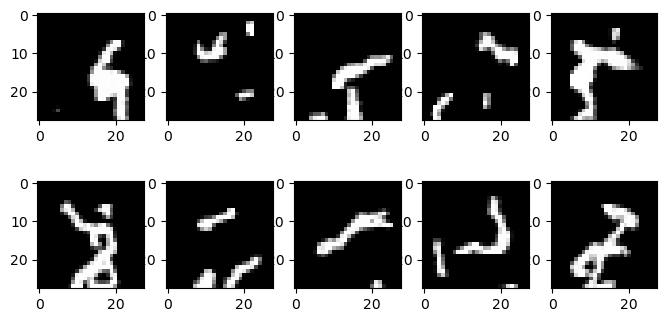

In [17]:
fig = plt.figure(figsize=(8, 4))
columns = 5
rows = 2
for i, img in enumerate(sampled_images):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img.squeeze().cpu().numpy(), cmap="gray")
plt.show()